In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import CLIPModel, CLIPImageProcessor
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
MEAN, STD = processor.image_mean, processor.image_std
SIZE = processor.size["shortest_edge"] if isinstance(processor.size, dict) else processor.size

transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

num_classes = len(train_dataset.classes)
print("class_to_idx:", train_dataset.class_to_idx)

# -------------------- CLIP backbone (frozen) --------------------
clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", weights_only=False).to(device)
for p in clip.parameters():
    p.requires_grad = False
clip.eval()  # we're extracting features only

# Feature dim after CLIP visual projection
feat_dim = clip.visual_projection.out_features  # e.g., 512 for ViT-B/32

@torch.no_grad()
def extract_image_features(imgs: torch.Tensor) -> torch.Tensor:
    """
    imgs: (N,3,H,W) CLIP-normalized
    returns: (N, feat_dim) projected CLIP image embeddings
    """
    vis_out = clip.vision_model(pixel_values=imgs)   # .pooler_output: (N, hidden)
    pooled = vis_out.pooler_output
    feats = clip.visual_projection(pooled)           # (N, feat_dim)
    return feats

# -------------------- Trainable projection + Center Loss --------------------
proj_dim = 128  # small embedding space for center loss
feat_proj = nn.Linear(feat_dim, proj_dim).to(device)

class CenterLoss(nn.Module):
    def __init__(self, num_classes: int, feat_dim: int, device):
        super().__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim, device=device))

    def forward(self, features: torch.Tensor, labels: torch.Tensor):
        # features: (N, feat_dim), labels: (N,) long
        centers_batch = self.centers[labels]
        return ((features - centers_batch) ** 2).sum() / (2.0 * features.size(0))

center_loss_fn = CenterLoss(num_classes=num_classes, feat_dim=proj_dim, device=device)

optimizer = optim.Adam([
    {"params": feat_proj.parameters(), "lr": 1e-3},
    {"params": center_loss_fn.parameters(), "lr": 5e-4},  # centers: smaller LR is typical
])


class_to_idx: {'Negative': 0, 'Positive': 1}


In [2]:
# -------------------- Train / Eval --------------------
def train_one_epoch():
    feat_proj.train()
    running = 0.0

    for imgs, labels in tqdm(train_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        with torch.set_grad_enabled(True):
            with torch.no_grad():  # backbone is frozen
                feats_clip = extract_image_features(imgs)        # (N, feat_dim)
            feats = feat_proj(feats_clip)                        # (N, proj_dim)
            loss = center_loss_fn(feats, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item() * imgs.size(0)
    return running / len(train_loader.dataset)

@torch.no_grad()
def evaluate():
    feat_proj.eval()
    correct = total = 0
    total_loss = 0.0

    centers = center_loss_fn.centers  # (C, D)
    for imgs, labels in tqdm(test_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        feats = feat_proj(extract_image_features(imgs))          # (N, D)
        total_loss += center_loss_fn(feats, y).item() * imgs.size(0)

        # nearest-center prediction (L2)
        dists = torch.cdist(feats, centers)                      # (N, C)
        preds = torch.argmin(dists, dim=1)                       # (N,)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total, total_loss / total

# -------------------- Train loop --------------------
epochs = 10
for ep in range(epochs):
    tr_loss = train_one_epoch()
    acc, val_loss = evaluate()
    print(f"Epoch {ep+1}/{epochs} | train_center_loss {tr_loss:.4f} | val_center_loss {val_loss:.4f} | acc_nc {acc:.3f}")


Epoch 1/10 | train_center_loss 39.5270 | val_center_loss 28.3753 | acc_nc 0.724


Epoch 2/10 | train_center_loss 26.0548 | val_center_loss 24.5644 | acc_nc 0.724


Epoch 3/10 | train_center_loss 22.9601 | val_center_loss 22.3783 | acc_nc 0.733


Epoch 4/10 | train_center_loss 21.2225 | val_center_loss 20.8185 | acc_nc 0.756


Epoch 5/10 | train_center_loss 19.9193 | val_center_loss 19.7975 | acc_nc 0.756


Epoch 6/10 | train_center_loss 18.8666 | val_center_loss 18.5594 | acc_nc 0.793


Epoch 7/10 | train_center_loss 17.9493 | val_center_loss 17.8101 | acc_nc 0.788


Epoch 8/10 | train_center_loss 17.1744 | val_center_loss 16.9740 | acc_nc 0.793


Epoch 9/10 | train_center_loss 16.4891 | val_center_loss 16.3208 | acc_nc 0.811


Epoch 10/10 | train_center_loss 15.8598 | val_center_loss 15.6698 | acc_nc 0.811


              precision    recall  f1-score   support

    Negative     0.8085    0.9682    0.8812       157
    Positive     0.8276    0.4000    0.5393        60

    accuracy                         0.8111       217
   macro avg     0.8180    0.6841    0.7102       217
weighted avg     0.8138    0.8111    0.7866       217

Confusion Matrix:
 [[152   5]
 [ 36  24]]


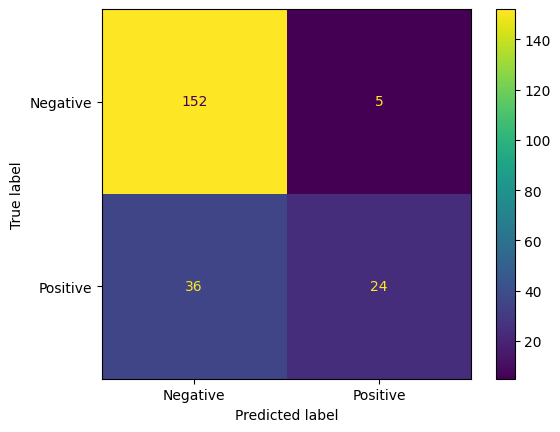

In [4]:

@torch.no_grad()
def collect_preds_center():
    feat_proj.eval()
    y_true, y_pred = [], []
    centers = center_loss_fn.centers
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = feat_proj(extract_image_features(imgs))
        dists = torch.cdist(feats, centers)
        preds = torch.argmin(dists, dim=1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = collect_preds_center()
print(classification_report(y_true, y_pred, target_names=train_dataset.classes, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes).plot()
plt.show()
